<a href="https://colab.research.google.com/github/MarcioB1999/Aprendizado_de_Maquina/blob/main/Regressao_pre%C3%A7o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from modelo import Modelo as md
import pandas as pd
import numpy as np

# **Manipulação dos Dados**

## Importação dos Dados

In [2]:
X = pd.read_csv('X.csv').iloc[:,1:]
X.head(5)

,floors,grade,bathrooms,condition,bedrooms,lat,sqft_living,sqft_living15,zipcode,sqft_above
0,2,9,2,4,3.0,47.4635,1970,2340,98027,1970
1,1,9,2,4,3.0,47.6833,2600,2380,98117,1700
2,2,8,2,3,5.0,47.5794,2820,2820,98029,2820
3,2,8,2,3,4.0,47.5150,3310,2380,98065,3310
4,1,8,2,3,4.0,47.5443,2160,1850,98006,1080


In [3]:
Y = pd.read_csv('Y.csv').iloc[:,1:]
Y.head(5)

,price
0,437500.0
1,790000.0
2,675000.0
3,555000.0
4,440000.0


## Transformação dos Dados

In [4]:
X.columns

Index(['floors', 'grade', 'bathrooms', 'condition', 'bedrooms', 'lat',
       'sqft_living', 'sqft_living15', 'zipcode', 'sqft_above'],
      dtype='object')

In [5]:
columnsMinMax = [
                 'floors',
                 'bathrooms',
                 'grade',
                 'lat',
                 'condition',
                 'bedrooms',
                 'zipcode',
                 ]
columnsMinMax

['floors', 'bathrooms', 'grade', 'lat', 'condition', 'bedrooms', 'zipcode']

In [6]:
columnsStander = ['sqft_above','sqft_living15','sqft_living',]
columnsStander

['sqft_above', 'sqft_living15', 'sqft_living']

In [7]:
modelo = md(len(X.columns))

In [8]:
X,_,_ = modelo.X_transform(X,columnsMinMax,columnsStander)
Y,scale_price = modelo.Y_transform(Y)

In [9]:
X_train,X_test,Y_train,Y_test = modelo.div_data(X,Y)

In [10]:
history = modelo.fit(X_train,Y_train)

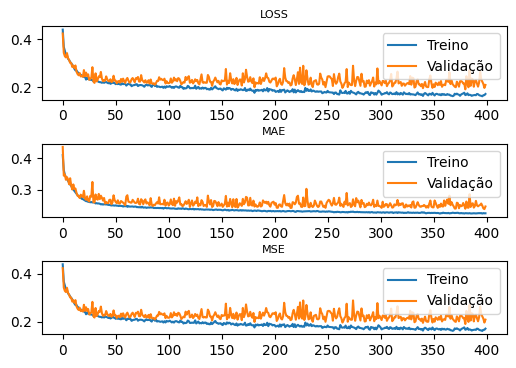

In [11]:
modelo.plot_metricas(history)

In [12]:
modelo.metricas_teste(X_test,Y_test)

metricas teste
136/136 [==============================] - 0s 2ms/step - loss: 0.2046 - mae: 0.2618 - mse: 0.2046 - mape: 440.7250
Loss = 0.20459550619125366
MAE = 0.26175475120544434
MSE = 0.20459550619125366
MAPE = 440.7249755859375


In [13]:
predict = scale_price.inverse_transform(modelo.predict(X_test).reshape(-1,1))
y_test = scale_price.inverse_transform(np.array(Y_test['price']).reshape(-1, 1))

136/136 [==============================] - 0s 1ms/step


In [14]:
residuos = modelo.residuos(y_test,predict)

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


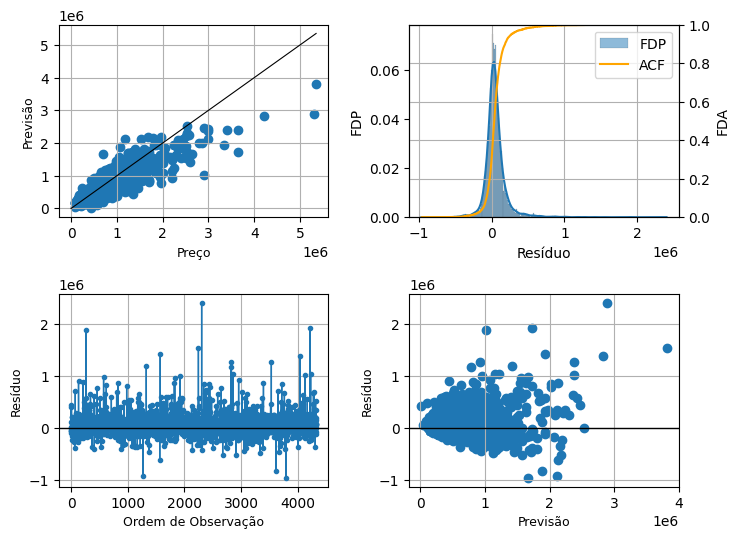

In [15]:
modelo.residual_plot(residuos,y_test,predict)

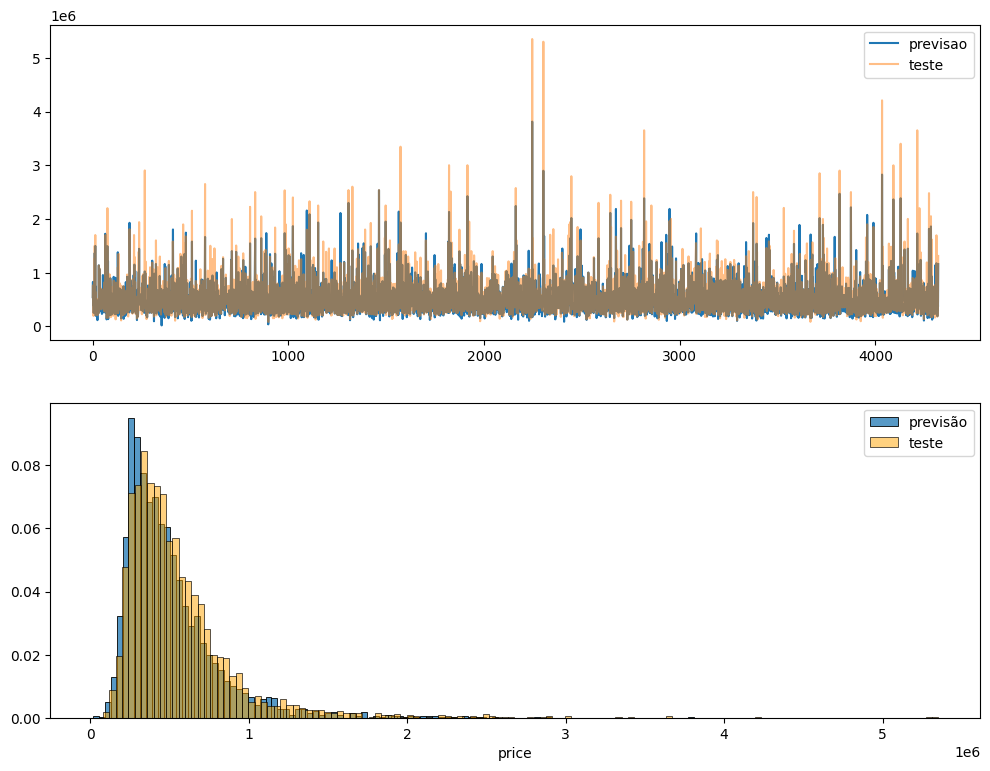

In [16]:
modelo.predict_plot(y_test,predict)

In [17]:
modelo.r2(y_test,predict)

0.7961399370769887